In [127]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [128]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

In [129]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

In [130]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["School", "Player_Type", "Position_Type", "Position"]

for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([X[col], test[col]]).astype(str)
    le.fit(all_values)
    
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [131]:
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

X["BMI"] = X["Weight"] / (X["Height"] / 100) ** 2
test["BMI"] = test["Weight"] / (test["Height"] / 100) ** 2

X = X.drop(columns=["School"])
test = test.drop(columns=["School"])

In [132]:
columns_to_drop = ["Player_Type", "Position_Type"]
X = X.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

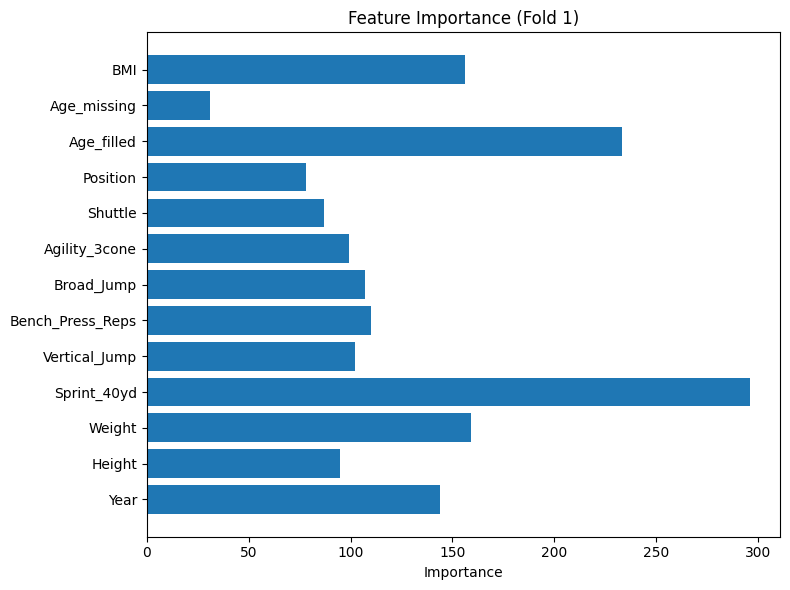

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [133]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=4,
    num_leaves=15,
    min_child_samples=30,
    min_split_gain=0.0,         # 追加1
    subsample=0.8,              # 追加2
    colsample_bytree=0.8,       # 追加3
    reg_alpha=3.0,              # 強化1
    reg_lambda=2.0,             # 強化2
    learning_rate=0.03,
    n_estimators=700,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")

In [134]:
test.head()

,Year,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Position,Age_filled,Age_missing,BMI
0,2017,1.9558,136.077711,5.27,76.20,21.0,289.56,8.39,5.09,10,22.0,0,355744.432268
1,2013,1.7780,83.460996,4.51,102.87,14.0,335.28,6.82,3.84,1,22.0,0,264009.801334
2,2018,1.8542,103.419060,4.52,101.60,14.0,327.66,7.13,4.34,15,21.0,0,300806.650816
3,2009,1.8034,98.429544,4.50,90.17,25.0,292.10,6.84,4.27,15,21.0,0,302650.463761
4,2018,1.8288,83.914588,4.36,80.01,13.0,302.26,6.93,4.40,1,23.0,0,250902.531314


# Position_Typeについて

In [135]:
# エンコード前のPosition列を再読み込みして復元
df_raw = pd.read_csv("../data/train.csv")
X["Position"] = df_raw["Position"]

test_raw = pd.read_csv("../data/test.csv")
test["Position"] = test_raw["Position"]



In [136]:
test.head()

,Year,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Position,Age_filled,Age_missing,BMI
0,2017,1.9558,136.077711,5.27,76.20,21.0,289.56,8.39,5.09,OG,22.0,0,355744.432268
1,2013,1.7780,83.460996,4.51,102.87,14.0,335.28,6.82,3.84,CB,22.0,0,264009.801334
2,2018,1.8542,103.419060,4.52,101.60,14.0,327.66,7.13,4.34,RB,21.0,0,300806.650816
3,2009,1.8034,98.429544,4.50,90.17,25.0,292.10,6.84,4.27,RB,21.0,0,302650.463761
4,2018,1.8288,83.914588,4.36,80.01,13.0,302.26,6.93,4.40,CB,23.0,0,250902.531314


# EDA（Position）


In [137]:
# Drafted率の高い順にPositionを並べる
position_stats = X.copy()
position_stats["Drafted"] = y  # yは目的変数
position_rate = position_stats.groupby("Position")["Drafted"].mean().sort_values(ascending=False)

print(position_rate)


Position
OLB    0.759162
DT     0.715000
OT     0.707547
DE     0.701571
TE     0.697531
CB     0.692073
FS     0.686747
ILB    0.677966
SS     0.655172
OG     0.642384
QB     0.623457
RB     0.612000
WR     0.594937
C      0.583333
S      0.560976
DB     0.500000
FB     0.487805
LS     0.307692
K      0.289474
P      0.227273
Name: Drafted, dtype: float64


In [138]:
# PositionをTarget Encoding（全体平均ベース、これは許容範囲）
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# Position_groupを作成（これは合法・安全）
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

# fold-safeな target encoding を実施
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0  # 初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)

# testデータには全体平均から算出（合法）
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

# 不要な文字列列は削除（エラー防止）
X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])


C:\Users\81807\AppData\Local\Temp\ipykernel_19684\327866840.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 0

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

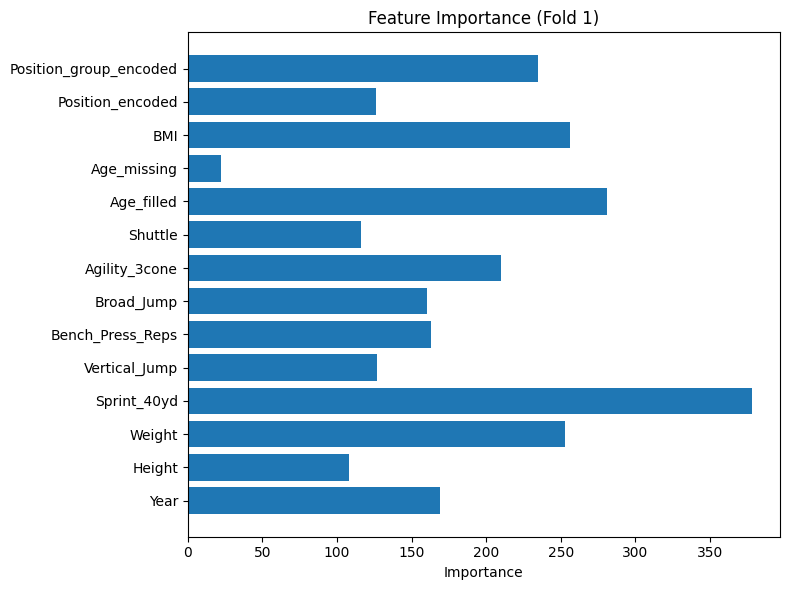

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [139]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=4,
    num_leaves=15,
    min_child_samples=30,
    min_split_gain=0.0,         # 追加1
    subsample=0.8,              # 追加2
    colsample_bytree=0.8,       # 追加3
    reg_alpha=3.0,              # 強化1
    reg_lambda=2.0,             # 強化2
    learning_rate=0.03,
    n_estimators=700,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

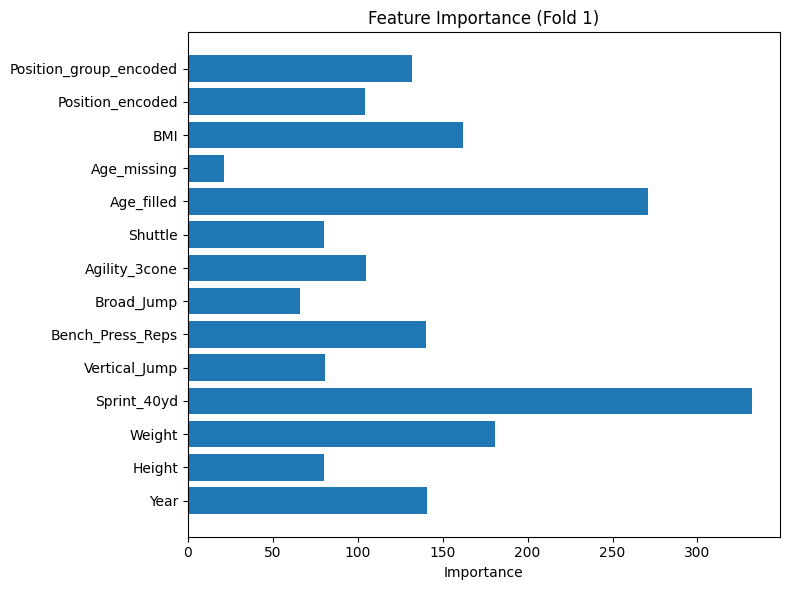

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [140]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=4,
    num_leaves=10,  # ←15→10
    min_child_samples=50,  # ←30→50
    reg_alpha=5.0,  # ←3.0→5.0
    reg_lambda=5.0,  # ←2.0→5.0
    learning_rate=0.03,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")

# LightGBM × Optuna による自動ハイパーパラメータチューニング

In [141]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold


In [142]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 8, 64),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "n_estimators": 700,
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "random_state": 42
    }

    aucs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, valid_idx in kf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric="auc",
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=30),
                      lgb.log_evaluation(0)
                  ])
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        aucs.append(auc)

    return sum(aucs) / len(aucs)


In [143]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2025-06-27 00:49:53,022] A new study created in memory with name: no-name-65f2da11-89fe-4652-8941-5d1d15a44c69


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-06-27 00:49:53,716] Trial 0 finished with value: 0.8312285334262975 and parameters: {'max_depth': 7, 'num_leaves': 15, 'min_child_samples': 45, 'learning_rate': 0.03712530770778812, 'subsample': 0.6563091955816236, 'colsample_bytree': 0.6660434380068975, 'reg_alpha': 3.053519446075641, 'reg_lambda': 6.825465688424151}. Best is trial 0 with value: 0.8312285334262975.


Early stopping, best iteration is:
[125]	valid_0's auc: 0.847279	valid_0's binary_logloss: 0.409844
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-06-27 00:49:54,340] Trial 1 finished with value: 0.8267397781614244 and parameters: {'max_depth': 5, 'num_leaves': 18, 'min_child_samples': 29, 'learning_rate': 0.013747874865388875, 'subsample': 0.9086553030314639, 'colsample_bytree': 0.7696147388327206, 'reg_alpha': 3.7568628529070045, 'reg_lambda': 3.6267828762561694}. Best is trial 0 with value: 0.8312285334262975.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:54,897] Trial 2 finished with value: 0.8230709754069965 and parameters: {'max_depth': 6, 'num_leaves': 59, 'min_child_samples': 76, 'learning_rate': 0.014344327624023245, 'subsample': 0.5589940658407437, 'colsample_bytree': 0.5923996663736503, 'reg_alpha': 9.461215594755286, 'reg_lambda': 6.297031473240323}. Best is trial 0 with value: 0.8312285334262975.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:55,612] Trial 3 finished with value: 0.8212718727486733 and parameters: {'max_depth': 3, 'num_leaves': 22, 'min_child_samples': 74, 'learning_rate': 0.015214006387482078, 'subsample': 0.7439797311793339, 'colsample_bytree': 0.6492279482519228, 'reg_alpha': 9.437289014333777, 'reg_lambda': 9.316701283734483}. Best is trial 0 with value: 0.8312285334262975.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:56,346] Trial 4 finished with value: 0.832358297179231 and parameters: {'max_depth': 5, 'num_leaves': 64, 'min_child_samples': 66, 'learning_rate': 0.029416846429042905, 'subsample': 0.6061278379813702, 'colsample_bytree': 0.7156921527110297, 'reg_alpha': 4.682378915433711, 'reg_lambda': 8.714707615313579}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:57,069] Trial 5 finished with value: 0.8225980137953327 and parameters: {'max_depth': 8, 'num_leaves': 9, 'min_child_samples': 85, 'learning_rate': 0.014365240948219594, 'subsample': 0.8946898878951707, 'colsample_bytree': 0.8066376541448825, 'reg_alpha': 4.736190002583495, 'reg_lambda': 4.856291781055802}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:49:57,623] Trial 6 finished with value: 0.8263574636296738 and parameters: {'max_depth': 4, 'num_leaves': 60, 'min_child_samples': 10, 'learning_rate': 0.023565174859858797, 'subsample': 0.5626488968319956, 'colsample_bytree': 0.8237944518705999, 'reg_alpha': 9.903678600346373, 'reg_lambda': 4.764048100044346}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:58,181] Trial 7 finished with value: 0.8232536481458128 and parameters: {'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 82, 'learning_rate': 0.013957436332432538, 'subsample': 0.9224318634599291, 'colsample_bytree': 0.7934281901300507, 'reg_alpha': 3.4430134806660107, 'reg_lambda': 0.14824525584846926}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:58,583] Trial 8 finished with value: 0.8290305989573895 and parameters: {'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 98, 'learning_rate': 0.0654502384878014, 'subsample': 0.6385038959536227, 'colsample_bytree': 0.9686959423945629, 'reg_alpha': 5.246545871049952, 'reg_lambda': 4.741368705600292}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:59,222] Trial 9 finished with value: 0.8230118296874827 and parameters: {'max_depth': 4, 'num_leaves': 38, 'min_child_samples': 87, 'learning_rate': 0.019594103496328386, 'subsample': 0.7391414642244314, 'colsample_bytree': 0.6049470058648934, 'reg_alpha': 8.791893245574713, 'reg_lambda': 4.256362433986844}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:49:59,743] Trial 10 finished with value: 0.8261003295060476 and parameters: {'max_depth': 6, 'num_leaves': 48, 'min_child_samples': 58, 'learning_rate': 0.007756115881379106, 'subsample': 0.5168637607187357, 'colsample_bytree': 0.5002999816492214, 'reg_alpha': 0.7241844201338785, 'reg_lambda': 9.489280730816805}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:00,266] Trial 11 finished with value: 0.8321181121784604 and parameters: {'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 46, 'learning_rate': 0.046925717351231924, 'subsample': 0.6506035712456834, 'colsample_bytree': 0.6853912507273938, 'reg_alpha': 1.683841839897343, 'reg_lambda': 7.005723510720108}. Best is trial 4 with value: 0.832358297179231.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:00,689] Trial 12 finished with value: 0.8358231732212736 and parameters: {'max_depth': 5, 'num_leaves': 47, 'min_child_samples': 59, 'learning_rate': 0.06596399116729391, 'subsample': 0.6410675548233564, 'colsample_bytree': 0.7169581518366747, 'reg_alpha': 0.487716552772236, 'reg_lambda': 7.729732853688835}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:01,083] Trial 13 finished with value: 0.8338944666225038 and parameters: {'max_depth': 5, 'num_leaves': 52, 'min_child_samples': 58, 'learning_rate': 0.09761761965190471, 'subsample': 0.8224761689052663, 'colsample_bytree': 0.8789327839542912, 'reg_alpha': 6.305895985666445, 'reg_lambda': 8.383839861627449}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:01,562] Trial 14 finished with value: 0.8329145294917456 and parameters: {'max_depth': 4, 'num_leaves': 51, 'min_child_samples': 47, 'learning_rate': 0.09546654150857245, 'subsample': 0.8283528509387396, 'colsample_bytree': 0.9066686986965221, 'reg_alpha': 6.575115474911873, 'reg_lambda': 8.044556944130367}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:01,973] Trial 15 finished with value: 0.8296953195476643 and parameters: {'max_depth': 5, 'num_leaves': 53, 'min_child_samples': 31, 'learning_rate': 0.08592452418244292, 'subsample': 0.8134838420327882, 'colsample_bytree': 0.8865801996001791, 'reg_alpha': 7.318662740246511, 'reg_lambda': 7.83759643897349}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:02,416] Trial 16 finished with value: 0.834860788587045 and parameters: {'max_depth': 3, 'num_leaves': 42, 'min_child_samples': 60, 'learning_rate': 0.05632033275443537, 'subsample': 0.9826233493007773, 'colsample_bytree': 0.8608568733715569, 'reg_alpha': 0.004269265014534118, 'reg_lambda': 2.4230141009629005}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:02,833] Trial 17 finished with value: 0.829757095287863 and parameters: {'max_depth': 3, 'num_leaves': 41, 'min_child_samples': 32, 'learning_rate': 0.05194311539070066, 'subsample': 0.9968562201552649, 'colsample_bytree': 0.9937024419975613, 'reg_alpha': 0.11975040440429707, 'reg_lambda': 2.513259561111449}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[221]	valid_0's auc: 0.798073	valid_0's binary_logloss: 0.461167
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overh

[I 2025-06-27 00:50:03,323] Trial 18 finished with value: 0.83247579861549 and parameters: {'max_depth': 3, 'num_leaves': 27, 'min_child_samples': 64, 'learning_rate': 0.06474491254053535, 'subsample': 0.6935005235493843, 'colsample_bytree': 0.9385571230116347, 'reg_alpha': 1.946524388093719, 'reg_lambda': 1.0683755482551098}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-06-27 00:50:03,849] Trial 19 finished with value: 0.8300958790363223 and parameters: {'max_depth': 4, 'num_leaves': 41, 'min_child_samples': 70, 'learning_rate': 0.03329585094928872, 'subsample': 0.9860498194550261, 'colsample_bytree': 0.8365997547367406, 'reg_alpha': 1.6176638676959592, 'reg_lambda': 2.4534127651667834}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:04,271] Trial 20 finished with value: 0.8353229441325503 and parameters: {'max_depth': 6, 'num_leaves': 33, 'min_child_samples': 51, 'learning_rate': 0.04711379963326971, 'subsample': 0.6963906824442017, 'colsample_bytree': 0.7428303759040854, 'reg_alpha': 0.04232211850286305, 'reg_lambda': 2.221198305425146}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:04,687] Trial 21 finished with value: 0.8355281986898033 and parameters: {'max_depth': 6, 'num_leaves': 33, 'min_child_samples': 56, 'learning_rate': 0.05198334476406364, 'subsample': 0.7030097952093769, 'colsample_bytree': 0.6993916820514339, 'reg_alpha': 0.3486260879748612, 'reg_lambda': 2.3905959078175343}. Best is trial 12 with value: 0.8358231732212736.


Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2025-06-27 00:50:05,412] Trial 22 finished with value: 0.8351289646301023 and parameters: {'max_depth': 6, 'num_leaves': 34, 'min_child_samples': 49, 'learning_rate': 0.0421089460341716, 'subsample': 0.702896465903674, 'colsample_bytree': 0.7396343394734111, 'reg_alpha': 1.1920570078160928, 'reg_lambda': 1.4025682602428335}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:05,877] Trial 23 finished with value: 0.8320530278486847 and parameters: {'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 37, 'learning_rate': 0.07453672629872576, 'subsample': 0.7818310615031653, 'colsample_bytree': 0.7027890636092723, 'reg_alpha': 2.3376030655115896, 'reg_lambda': 5.970473931507761}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[101]	valid_0's auc: 0.8531	valid_0's binary_logloss: 0.415016
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

[I 2025-06-27 00:50:06,327] Trial 24 finished with value: 0.8297655328556596 and parameters: {'max_depth': 6, 'num_leaves': 36, 'min_child_samples': 51, 'learning_rate': 0.02808634457707462, 'subsample': 0.6995910501528354, 'colsample_bytree': 0.6162901232626565, 'reg_alpha': 0.7509383820992825, 'reg_lambda': 3.6014597246782856}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:06,723] Trial 25 finished with value: 0.8170937658393139 and parameters: {'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 20, 'learning_rate': 0.005516817274210156, 'subsample': 0.5925173783600968, 'colsample_bytree': 0.7559846686848407, 'reg_alpha': 2.665069372757716, 'reg_lambda': 3.3785903277491354}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[11]	valid_0's auc: 0.834576	valid_0's binary_logloss: 0.628651
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGB

[I 2025-06-27 00:50:07,057] Trial 26 finished with value: 0.8317363530041607 and parameters: {'max_depth': 6, 'num_leaves': 37, 'min_child_samples': 42, 'learning_rate': 0.040228889982017874, 'subsample': 0.6812333648921136, 'colsample_bytree': 0.5477062641566888, 'reg_alpha': 0.7528947870969158, 'reg_lambda': 1.560646013869587}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:07,439] Trial 27 finished with value: 0.8347360285473661 and parameters: {'max_depth': 5, 'num_leaves': 45, 'min_child_samples': 54, 'learning_rate': 0.05670501622117039, 'subsample': 0.6117437841224381, 'colsample_bytree': 0.7430698440508375, 'reg_alpha': 0.22429036383098078, 'reg_lambda': 0.3748313734947968}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:07,998] Trial 28 finished with value: 0.8333996579312171 and parameters: {'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 39, 'learning_rate': 0.07503420949085321, 'subsample': 0.7565929429515351, 'colsample_bytree': 0.6453651157054464, 'reg_alpha': 1.2747527291362704, 'reg_lambda': 5.591684302948724}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:08,737] Trial 29 finished with value: 0.8343087282501607 and parameters: {'max_depth': 7, 'num_leaves': 12, 'min_child_samples': 65, 'learning_rate': 0.03397214748993238, 'subsample': 0.5010699351777981, 'colsample_bytree': 0.6704908299448199, 'reg_alpha': 2.6991699294995786, 'reg_lambda': 7.183006093710203}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[288]	valid_0's auc: 0.805371	valid_0's binary_logloss: 0.458312
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-06-27 00:50:09,247] Trial 30 finished with value: 0.8325932009994139 and parameters: {'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 75, 'learning_rate': 0.04644246788378222, 'subsample': 0.6603820230320159, 'colsample_bytree': 0.7149643300568771, 'reg_alpha': 3.463166641101507, 'reg_lambda': 3.0112901133413237}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:09,897] Trial 31 finished with value: 0.8354577582862109 and parameters: {'max_depth': 6, 'num_leaves': 33, 'min_child_samples': 52, 'learning_rate': 0.03915329375610892, 'subsample': 0.7109315927354528, 'colsample_bytree': 0.739332138793666, 'reg_alpha': 1.0052967924225658, 'reg_lambda': 1.4782005149202098}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:10,477] Trial 32 finished with value: 0.835773172025398 and parameters: {'max_depth': 6, 'num_leaves': 25, 'min_child_samples': 53, 'learning_rate': 0.036840129814902124, 'subsample': 0.7239923391012192, 'colsample_bytree': 0.7844266302637667, 'reg_alpha': 0.7578879732073687, 'reg_lambda': 1.9990194994471728}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:11,288] Trial 33 finished with value: 0.8346922815400755 and parameters: {'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 56, 'learning_rate': 0.021488337748315506, 'subsample': 0.739940835122491, 'colsample_bytree': 0.7811546279233347, 'reg_alpha': 2.1860070499899424, 'reg_lambda': 1.7449637250373529}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:11,998] Trial 34 finished with value: 0.835624162282997 and parameters: {'max_depth': 5, 'num_leaves': 25, 'min_child_samples': 61, 'learning_rate': 0.037309211007085945, 'subsample': 0.7818692569229211, 'colsample_bytree': 0.7760644482802799, 'reg_alpha': 1.1367838456476256, 'reg_lambda': 0.7695424254077939}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:12,479] Trial 35 finished with value: 0.8271824261347411 and parameters: {'max_depth': 5, 'num_leaves': 24, 'min_child_samples': 68, 'learning_rate': 0.0290025597559941, 'subsample': 0.7975615610643846, 'colsample_bytree': 0.770582567571746, 'reg_alpha': 4.07583549631518, 'reg_lambda': 0.679559303893405}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:12,965] Trial 36 finished with value: 0.8328153584752318 and parameters: {'max_depth': 5, 'num_leaves': 19, 'min_child_samples': 63, 'learning_rate': 0.0629498111751507, 'subsample': 0.8576476636108235, 'colsample_bytree': 0.8341332004595204, 'reg_alpha': 1.5131105763427721, 'reg_lambda': 0.8222290972857846}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:13,551] Trial 37 finished with value: 0.8344415894420841 and parameters: {'max_depth': 4, 'num_leaves': 18, 'min_child_samples': 70, 'learning_rate': 0.034888789912961876, 'subsample': 0.7740302143111388, 'colsample_bytree': 0.7023870931853387, 'reg_alpha': 0.6069742704162884, 'reg_lambda': 3.9240515049961426}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:14,065] Trial 38 finished with value: 0.828602370950511 and parameters: {'max_depth': 5, 'num_leaves': 16, 'min_child_samples': 82, 'learning_rate': 0.024160474341530763, 'subsample': 0.7294685621481566, 'colsample_bytree': 0.6414452534067192, 'reg_alpha': 3.024226381933261, 'reg_lambda': 3.057098031370349}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:14,900] Trial 39 finished with value: 0.8285168039266277 and parameters: {'max_depth': 5, 'num_leaves': 28, 'min_child_samples': 43, 'learning_rate': 0.01781743856705939, 'subsample': 0.8583358991545904, 'colsample_bytree': 0.8160833822092419, 'reg_alpha': 4.16682564988141, 'reg_lambda': 0.014490187086600437}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:15,282] Trial 40 finished with value: 0.8314671707343354 and parameters: {'max_depth': 4, 'num_leaves': 57, 'min_child_samples': 61, 'learning_rate': 0.07589363825649464, 'subsample': 0.6327350621563472, 'colsample_bytree': 0.7925636966521508, 'reg_alpha': 2.121101069391117, 'reg_lambda': 2.0110513339150127}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:15,894] Trial 41 finished with value: 0.8348875810356816 and parameters: {'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 53, 'learning_rate': 0.038152414117801875, 'subsample': 0.7207755300202965, 'colsample_bytree': 0.7320164625044753, 'reg_alpha': 1.0456330597160772, 'reg_lambda': 1.2646538673876067}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-06-27 00:50:16,543] Trial 42 finished with value: 0.8353247886802991 and parameters: {'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 55, 'learning_rate': 0.02678394915587197, 'subsample': 0.6739097433974148, 'colsample_bytree': 0.7624283961466081, 'reg_alpha': 0.45944514167311457, 'reg_lambda': 1.8191799779704998}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:17,128] Trial 43 finished with value: 0.8341088249349033 and parameters: {'max_depth': 7, 'num_leaves': 34, 'min_child_samples': 72, 'learning_rate': 0.05124576701088743, 'subsample': 0.7666992350849785, 'colsample_bytree': 0.6752628163343644, 'reg_alpha': 1.1859498752266462, 'reg_lambda': 0.6667924954451998}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:17,654] Trial 44 finished with value: 0.8345379341451759 and parameters: {'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 77, 'learning_rate': 0.04217798679191255, 'subsample': 0.5718352076287286, 'colsample_bytree': 0.7243130325481236, 'reg_alpha': 0.9282596346061799, 'reg_lambda': 5.383572315759622}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[44]	valid_0's auc: 0.849206	valid_0's binary_logloss: 0.435915
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't

[I 2025-06-27 00:50:18,679] Trial 45 finished with value: 0.8282430205550506 and parameters: {'max_depth': 6, 'num_leaves': 25, 'min_child_samples': 46, 'learning_rate': 0.012171868768230837, 'subsample': 0.7167766076569778, 'colsample_bytree': 0.7850783175235423, 'reg_alpha': 1.741986727643859, 'reg_lambda': 9.825187889215076}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:19,251] Trial 46 finished with value: 0.8341611121861913 and parameters: {'max_depth': 5, 'num_leaves': 64, 'min_child_samples': 59, 'learning_rate': 0.03291882571369788, 'subsample': 0.6599679585506336, 'colsample_bytree': 0.694328165298547, 'reg_alpha': 0.4949035766834154, 'reg_lambda': 3.021199105158566}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-27 00:50:19,774] Trial 47 finished with value: 0.8330440893418238 and parameters: {'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 37, 'learning_rate': 0.06116545180704605, 'subsample': 0.6205359880121402, 'colsample_bytree': 0.8106720250824512, 'reg_alpha': 2.6053322384331103, 'reg_lambda': 6.60791603805848}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:20,210] Trial 48 finished with value: 0.8330967223703176 and parameters: {'max_depth': 5, 'num_leaves': 22, 'min_child_samples': 92, 'learning_rate': 0.046385516716217524, 'subsample': 0.7487614882181823, 'colsample_bytree': 0.5675288714720447, 'reg_alpha': 1.3514287666924483, 'reg_lambda': 4.1656117535579575}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-27 00:50:20,988] Trial 49 finished with value: 0.8272928661662833 and parameters: {'max_depth': 7, 'num_leaves': 45, 'min_child_samples': 67, 'learning_rate': 0.025515557247769154, 'subsample': 0.5869220202385436, 'colsample_bytree': 0.650764577745183, 'reg_alpha': 5.305153943644239, 'reg_lambda': 8.986560297096279}. Best is trial 12 with value: 0.8358231732212736.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [144]:
print("Best AUC:", study.best_value)
print("Best params:", study.best_params)


Best AUC: 0.8358231732212736
Best params: {'max_depth': 5, 'num_leaves': 47, 'min_child_samples': 59, 'learning_rate': 0.06596399116729391, 'subsample': 0.6410675548233564, 'colsample_bytree': 0.7169581518366747, 'reg_alpha': 0.487716552772236, 'reg_lambda': 7.729732853688835}


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

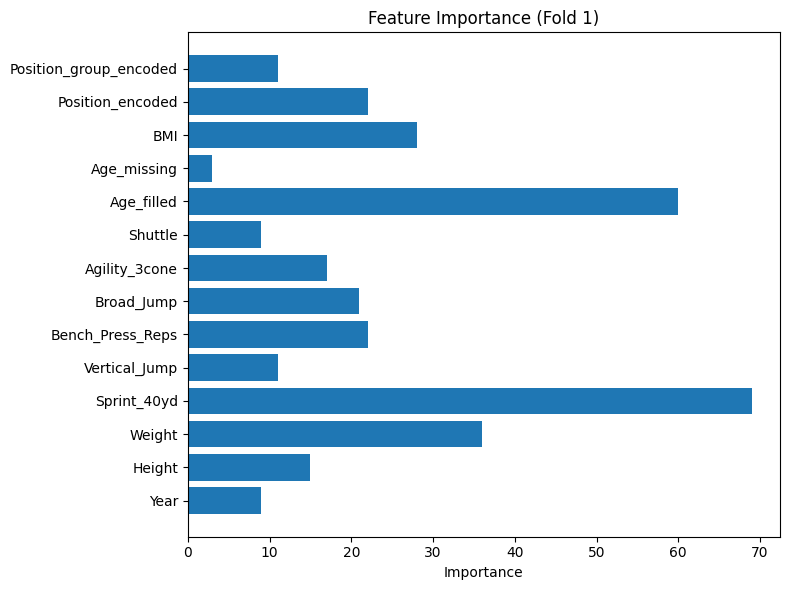

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=5,
    num_leaves=47,
    min_child_samples=59,
    learning_rate=0.06596399116729391,
    n_estimators=700,
    subsample=0.6410675548233564,
    colsample_bytree=0.7169581518366747,
    reg_alpha=0.487716552772236,
    reg_lambda=7.729732853688835,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(0)  # ログ非表示
    ]
)



    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    # ★ Fold 1 のあとに一度だけ重要度を出力
    if fold == 0:
        import matplotlib.pyplot as plt
        importances = model.feature_importances_
        feature_names = X.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")

In [147]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 特徴量リスト（X に現在残っている列がそのまま最終特徴量）
feature_cols = X.columns

# test データも同じ列順で整形（予測対象）
X_test = test[feature_cols]

# LightGBMモデルで予測（Drafted=1 の確率）
y_pred = model.predict_proba(X_test)[:, 1]

# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred
})

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

# ファイル名を YYYYMMDD_HHMM 形式で構成
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
filename = f"submission_{timestamp}.csv"
save_path = os.path.join(save_dir, filename)

submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_20250627_0055.csv
